<h1>Classification Tasks on Audio</h1>

<p>We are going to investigate building and tuning models to perform two separate classification tasks on our generated waveform dataset:</p>

<ul>
    <li>predicting sample waveforms</li>
    <li>predicting sample pitch class</li>
</ul>

<p>We will also set out to build these models in both Tensorflow and Pytorch.</p>

<h2>Tensorflow</h2>

<h3>Predicting Waveforms</h3>

<p>The first task will be to predict the waveform of an input audio sample.</p>

In [1]:
import pickle

import pandas as pd
import numpy as np

#This is so we can replicate our results later
#from our pandas DF shuffling
RANDOM_STATE = 1

In [3]:
#Load up the dataframe we generated previously
with open('osc_dataset.pickle', 'rb') as handle:
    df = pickle.load(handle)

#Shuffle its brains out
df = df.sample(frac=1, random_state=RANDOM_STATE)

<p>Just to refresh out memory, there are only four waveforms that we generated for our dataset:</p>

In [4]:
pd.unique(df['osc'])

array(['sin', 'squ', 'tri', 'saw'], dtype=object)

<p>Let's now us pd.factorize to turn our string waveform names into integer values.</p>

In [8]:
df['osc_cat'], osc_uniques = pd.factorize(df['osc'])

In [15]:
#Notice the conversion of the string categories to integers
for i in range(5):
    print('String: {} => Integer: {}'.format(df['osc'].iloc[i], df['osc_cat'].iloc[i]))

String: sin => Integer: 0
String: squ => Integer: 1
String: tri => Integer: 2
String: squ => Integer: 1
String: squ => Integer: 1


In [16]:
#And, we can us osc_uniques to convert the integers back
osc_uniques[df['osc_cat']]

Index(['sin', 'squ', 'tri', 'squ', 'squ', 'squ', 'tri', 'saw', 'squ', 'squ',
       ...
       'tri', 'sin', 'tri', 'tri', 'saw', 'saw', 'squ', 'sin', 'saw', 'sin'],
      dtype='object', length=25600)

<p>For Tensorflow, it is important for us to cast the target integers to float32s.</p>

In [17]:
df['osc_cat'] = np.asarray(df['osc_cat']).astype('float32')

<p>Our audio inputs are going to be of length $s_{rate} \times length$</p>

In [22]:
print('s_rate = {}'.format(df['audio'].iloc[0].shape[0]))
print('length = {}'.format(df['length'].iloc[0]))

s_rate = 22050
length = 1


<p>The input tensor shapes will be $(batch size, 22050, 1)$. The final dimension is the number of filters and, in this case, there is only a single input filter.</p>

<h3>Model</h3>
<p>The same model will be used for both classification tasks. The general structure is as follows:</p>

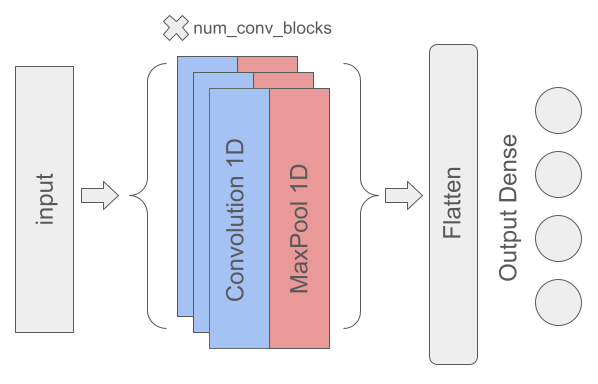

<p>The hyperparameters embedded in the model that will be searched are:</p>

<ul>
    <li>number of convolution-max pool blocks--$num\_conv\_blocks$</li>
    <li>base number of filters for each convolution block--the $i$-th convolution block will have $base\_filters \cdot 2^{i}$ filters</li>
    <li>kernel size of convolution filters--$base\_kernel$</li>
    <li>stride of convolution filters--$base\_stride$</li>
    <li>pool size of each max pool layer--$base\_pool$</li>
    <li>activation function--$act$</li>
</ul>

<p>The training loop hyperparameters that will be searched are:</p>

<ul>
    <li>maximum epoches--$max\_epoch$</li>
    <li>batch size--$batch\_size$</li>
    <li>learning rate--$init\_learning\_rate$</li>
</ul>


<p>In the current classification task, the size of the output is the number of waveforms--$4$.</p>

In [ ]:
import tensorflow as tf
#The following is for tf.Dataset prefetch
#it, likely, isn't a factor when working with such a small
#training set locally
AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_model(args):
    base_filters, base_kernel, base_stride, base_pool, num_conv_blocks, act, output_class = args[0], args[1], args[2], args[3], args[4], args[5], args[6]
    input_layer = tf.keras.Input(shape=[int(df['sampling_rate'].iloc[0]), 1], name='Input')
    x = input_layer
    for i in range(num_conv_blocks):
        x = tf.keras.layers.Conv1D(filters=base_filters * 2 ** i, kernel_size=base_kernel, strides=base_stride, activation=act, name='Conv{}'.format(i+1))(x)
        x = tf.keras.layers.MaxPool1D(pool_size=base_pool, name='Pool{}'.format(i+1))(x)
    x = tf.keras.layers.Flatten(name='Flatten')(x)
    output_layer = tf.keras.layers.Dense(output_class, activation='softmax', name='Output')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

<h3>Dataset</h3>

<p>The following code builds the Tensorflow train/val/test datasets on the fly. Normally, we would make the dataset once and walk away but we are testing batch size changes so we will regenerate the datasets when we change batch sizes.</p>

<p>We could use a dataset.unbatch/rebatch approach when changing batch sizes but rebuilding the datasets is fairly straightforward with a small-ish overhead.</p>

In [ ]:
SPLIT_DICT = {'train': 0.95, 
              'val': 0.025,
              'test': 0.025}

def break_df_into_dataset(df, feature_col, target_col, split_dict, batch_size, autotune, random=1):
    num_samples = df.shape[0]
    index_cum = 0
    dataset = {}
    for set_name in split_dict.keys():
        curr_split = int(split_dict[set_name] * num_samples)
        input = df[feature_col].reset_index(drop=True).iloc[index_cum: index_cum + curr_split].tolist()
        target = df[target_col].iloc[index_cum: index_cum + curr_split].tolist()
        index_cum += curr_split
        temp = tf.data.Dataset.from_tensor_slices((input, target))
        temp = temp.map(lambda x, y: (tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1))).cache().batch(batch_size).prefetch(autotune)
        dataset[set_name] = temp
    return dataset

<p>The following wrapper builds a learning rate annealer.</p>

In [ ]:
def scheduler(max_epoch):
    def inner_wrap(epoch, lr):
      if epoch < int(max_epoch / 2):
        return lr
      else:
        return lr * tf.math.exp(-0.1)
    return inner_wrap

<p>Finally, we make a function that outputs the necessary training classes used for our hyperparameter search.</p>

In [ ]:
def build_train_classes(max_epochs, learning_rate):
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler(max_epochs))
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    return lr_callback, callback, optimizer, loss

<h3>Hyperparameter Search</h3>

<p>Gone are the days where a full-on grid search makes any sense! Instead, we are going to use a stochastic search pattern.</p>

<p>Hefty note with these classification tasks on this dataset--they are very competently tackled with this model infrastructure. The following hyperparameter search could easily be replaced with the laziest guess-and-check approach imaginable.</p>

In [ ]:
import itertools
import time

#number of hyperparameter searches to make
NUM_EXP = 100

#Rough guesstimate of parameter values
batch_size = [32, 64, 128, 256]
learning_rate = [0.001, 0.0005, 0.002]
max_epochs = [3, 5, 10, 15]
base_filters = [2, 4, 8]
base_kernels = [4, 8, 10]
base_stride = [1, 2, 4]
base_pool = [3, 4, 5]
num_conv_blocks = [3, 4, 5]
#For a model this shallow, ReLU is almost certainly
#good enough but, hey, why not try out new things
activations = ['relu', 'selu', 'elu']

#Create an exhaustive list of all permutations of
#the hyperparameters
hyperparameters = list(itertools.product(batch_size, learning_rate, 
                                         max_epochs, base_filters,
                                         base_kernels, base_stride,
                                         base_pool, num_conv_blocks,
                                         activations))

parameters = []

#Shuffle the bejesus out of the list and take only NUM_EXP of them
for i in np.random.choice(np.arange(len(hyperparameters)), size=NUM_EXP, replace=False):
    temp = {}
    temp['batch_size'] = hyperparameters[i][0]
    temp['init_learning_rate'] = hyperparameters[i][1]
    temp['max_epochs'] = hyperparameters[i][2]
    temp['base_filters'] = hyperparameters[i][3]
    temp['base_kernels'] = hyperparameters[i][4]
    temp['base_stride'] = hyperparameters[i][5]
    temp['base_pool'] = hyperparameters[i][6]
    temp['num_conv_blocks'] = hyperparameters[i][7]
    temp['activations'] = hyperparameters[i][8]
    parameters.append(temp)

#Sort the list according to batch_size so that the dataset
#is re-made as few times as possible
parameters = sorted(parameters, key=lambda x: x['batch_size'])

del hyperparameters

<p>Finally!! We set up a series of training experiments with the above list of hyperparamters and see which set up performs the best.</p>

<p>We were pretty... ahem... lazy about hyperparameters and, frankly, a bunch of them straight up won't work.</p>

<p>At the end of trails, we will toss all of the results into a pandas dataframe and export it to a pickle!</p>

In [ ]:
train = True

In [ ]:
search_history = []
prev_batch_size = -1
total_time_start = time.time()
if train:
    for i, params in enumerate(parameters):
        tf.keras.backend.clear_session()
        print('{}'.format(i), '='*10)
        try:
            temp = {}
            if params['batch_size'] != prev_batch_size:
                dataset = break_df_into_dataset(df, 'audio', 'osc_cat', SPLIT_DICT, params['batch_size'], AUTOTUNE)
                prev_batch_size = params['batch_size']
            start = time.time()
            lr_callback, callback, optimizer, loss = build_train_classes(params['max_epochs'], params['init_learning_rate'])
            model = build_model([params['base_filters'], params['base_kernels'], 
                                 params['base_stride'], params['base_pool'], 
                                 params['num_conv_blocks'], params['activations'], 
                                 osc_uniques.shape[0]])
            model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
            
            history = model.fit(dataset['train'], epochs=params['max_epochs'], batch_size=params['batch_size'], verbose=0, 
                                validation_data=dataset['val'], validation_batch_size=params['batch_size'], 
                                callbacks=[lr_callback, callback])
            temp['train_acc'] = history.history['accuracy']
            temp['train_loss'] = history.history['loss']
            temp['val_acc'] = history.history['val_accuracy']
            temp['val_loss'] = history.history['val_accuracy']
            temp['learning_rates'] = history.history['lr']
            temp['realized_epochs'] = len(history.history['lr'])
            
            test_history = model.evaluate(dataset['test'], batch_size=params['batch_size'])
            temp['test_loss'], temp['test_acc'] = test_history
            temp['num_params'] = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    
            print('<{} Filters> <{} Kernel> <{} Stride> <{} Pool> <{} Conv Blocks>'.format(params['base_filters'], params['base_kernels'], 
                                                                                           params['base_stride'], params['base_pool'], 
                                                                                           params['num_conv_blocks']))
            
            print('<{} Epochs> <{} Batch Size> <{} Initial Learning Rate>'.format(params['max_epochs'], params['batch_size'], params['init_learning_rate']))
            temp['train_time'] = time.time() - start
            print('Accuracy = {} Parameters = {}'.format(temp['test_acc'], temp['num_params']))
            print('Training took {0:.2f} seconds'.format(temp['train_time']))
        except Exception as e:
            temp['error'] = e
            temp['accuracy'] = -1
            print('Not trainable')
        
        temp.update(params)
        search_history.append(temp)

total_train_time = time.time() - total_time_start 

train = False

training_df_osc = pd.DataFrame(search_history)

with open('training_df_oscTF.xlsx', 'wb') as handle:
    pickle.dump(training_df_osc, handle)

<h3>Predicting Pitch</h3>

<p>We can more-or-less reuse the entirety of the above code to predict the pitch of the input sample.</p>

In [ ]:
df['freq_cat'], freq_uniques = pd.factorize(df['freq'])
df['freq_cat'] = np.asarray(df['freq_cat']).astype('float32')

In [ ]:
train = True

In [ ]:
search_history = []
prev_batch_size = -1
total_time_start = time.time()
if train:
    for i, params in enumerate(parameters):
        tf.keras.backend.clear_session()
        print('{}'.format(i), '=' * 10)
        try:
            temp = {}
            if params['batch_size'] != prev_batch_size:
                dataset = break_df_into_dataset(df, 'audio', 'freq_cat', SPLIT_DICT, params['batch_size'], AUTOTUNE)
                prev_batch_size = params['batch_size']
            start = time.time()
            lr_callback, callback, optimizer, loss = build_train_classes(params['max_epochs'], params['init_learning_rate'])
            model = build_model([params['base_filters'], params['base_kernels'], 
                                 params['base_stride'], params['base_pool'], 
                                 params['num_conv_blocks'], params['activations'], 
                                 freq_uniques.shape[0]])
            model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
            
            history = model.fit(dataset['train'], epochs=params['max_epochs'], batch_size=params['batch_size'], verbose=0, 
                                validation_data=dataset['val'], validation_batch_size=params['batch_size'], 
                                callbacks=[lr_callback, callback])
            temp['train_acc'] = history.history['accuracy']
            temp['train_loss'] = history.history['loss']
            temp['val_acc'] = history.history['val_accuracy']
            temp['val_loss'] = history.history['val_accuracy']
            temp['learning_rates'] = history.history['lr']
            temp['realized_epochs'] = len(history.history['lr'])
            
            test_history = model.evaluate(dataset['test'], batch_size=params['batch_size'])
            temp['test_loss'], temp['test_acc'] = test_history
            temp['num_params'] = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    
            print('<{} Filters> <{} Kernel> <{} Stride> <{} Pool> <{} Conv Blocks>'.format(params['base_filters'], params['base_kernels'], 
                                                                                           params['base_stride'], params['base_pool'], 
                                                                                           params['num_conv_blocks']))
            
            print('<{} Epochs> <{} Batch Size> <{} Initial Learning Rate>'.format(params['max_epochs'], params['batch_size'], params['init_learning_rate']))
            temp['train_time'] = time.time() - start
            print('Accuracy = {} Parameters = {}'.format(temp['test_acc'], temp['num_params']))
            print('Training took {0:.2f} seconds'.format(temp['train_time']))
        except Exception as e:
            temp['error'] = e
            temp['accuracy'] = -1
            print('Not trainable')
            print(e)
        
        temp.update(params)
        search_history.append(temp)

total_train_time = time.time() - total_time_start 

train = False

training_df_freq = pd.DataFrame(search_history)

with open('training_df_freqTF.xlsx', 'wb') as handle:
    pickle.dump(training_df_freq, handle)

<p>The next notebook will recreate all of the above in PyTorch!</p>